In [1]:
import numpy as np
import os
import matplotlib.cm as cm
from scipy.special import expit as invlogit
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
import scipy.stats as st
from scipy.stats import norm
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import theano.tensor as tt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)

# Bayesian approach to testosterone effects estimation in risk-taking task
Estimation effects of testosterone application on decision making process (see. Effects of Testosterone Application on Loss Aversion and Risk Taking under Different Framing)

toDo: add task design (workflow) and short description

## Cumulative prospect theory

According  to prospect theory  (Fox, C. R. & Poldrack, R. A. Prospect Theory 149 Applications to Riskless Choice 151)  choice between two gambles is based on subjective value that represents  its desirability to decision maker. The value $V$ for simple prospect  that payoff $x$  with probability $p$  is given by  $V(x,p)=\omega(x)v(x)$ ,  where $w(x)$ measures impact effect of probability and $v(x)$ is subjective value of money.  The subjective value of payoff is  defined as power function from payoff 

$$V(A) = \sum v(x_i)*\omega(p_i)$$

where $V(A)$ - value function, $\omega(p_i)$ - decision weights for for gains and losses


$$ v(x_i) = \begin{cases} 
    	x^{\alpha}, 
    	& \text{if}\, (x)>0 \\
    	-\lambda (-x)^{\beta}, & \text{else}
    \end{cases}$$
$$ \omega(p) = \frac{p^{c_{ind}}}{[p^{c_{ind}} + (1-p)^{c_{ind}}]^{1/{c_{ind}}}} $$
where $ind = +,\text{ for gain }, - \text{ loss }$

With accordance to prospect theory the decision maker should always choose an option with a larger subjective value. A 0 to 1 choice probability is usually described by exponential transform, which leads to logistic function choice function:

$$p(A,B)  = \frac{1}{1+e^{\phi(V(B)-V(A))}}$$
A - Game, B - sure, in our case

Later we will call difference $V(B)-V(A)$ as **Gap**



**Testosterone related parameters**


Testing how testosterone influences on decision making process
$$\theta = logit(p_i)  = (a_j+a_{cond}) + (\beta_j+\beta_{cond})*gap(A,B,\alpha,c)$$

## Data processing step


toDo: add data description here

Basic preprocessing steps

### Data from risk-taking task

In [2]:
df = pd.read_csv('Framing.csv',sep = ';')
m_df = pd.melt(df, id_vars='ID', value_vars=list(df.columns[1:]), value_name='Strategy')
m_df['Test'] = 1
m_df.loc[m_df['variable'].str.contains('P'),'Test'] = 0
m_df['Win'] = 1
m_df.loc[m_df['variable'].str.contains('_L'),'Win'] = 0
m_df['P'] = m_df.apply(lambda row: float(row.variable[-3:]), axis=1)
m_df.drop("variable", axis=1, inplace = True)
m_df.Strategy = m_df.Strategy - 1
win_money = {0.9: {'A': 2000, 'B': 1500}, 0.7: {'A': 500, 'B': 250}, 0.5: {'A': 1000, 'B': 500}, 
             0.3: {'A': 1500, 'B': 500}, 0.1: {'A': 250, 'B': 50}}
loss_money = {0.9: {'A': 2400, 'B': 1200}, 0.7: {'A': 600, 'B': 200}, 0.5: {'A': 1000, 'B': 500}, 
             0.3: {'A': 1800, 'B': 600}, 0.1: {'A': 1200, 'B': 400}}

m_df['A'] = 0
m_df['B'] = 1
m_df.loc[m_df['Win']== 1,'A'] = m_df.loc[m_df['Win']== 1].apply(lambda row: win_money[row.P]['A'], axis=1)
m_df.loc[m_df['Win']== 1,'B'] = m_df.loc[m_df['Win']== 1].apply(lambda row: win_money[row.P]['B'], axis=1)
m_df.loc[m_df['Win']== 0,'A'] = m_df.loc[m_df['Win']== 0].apply(lambda row: loss_money[row.P]['A'], axis=1)
m_df.loc[m_df['Win']== 0,'B'] = m_df.loc[m_df['Win']== 0].apply(lambda row: loss_money[row.P]['B'], axis=1)

m_df["Inds"] = pd.Categorical(m_df['ID']).codes
print(f'Number of inds: {len(pd.unique(m_df.Inds))}')
m_df.loc[m_df['Win']== 0,['A','B']] = -1*m_df.loc[m_df['Win']== 0,['A','B']]
m_df['GameId'] = 0    
grouped = m_df.groupby(['Win','P','Test'])
key_list = list(grouped.groups.keys())
for i,key in zip(range(len(key_list)),key_list):
    m_df.loc[grouped.groups[key_list[i]], 'GameId']  = i
    
m_df['TypeCode'] = 0
hormones = [0, 1, 0, 1]
win =  [1, 1, 0, 0]
codes = [0,1,2,3]
for c,h,w in zip(codes,hormones, win):
    m_df.loc[(m_df['Test']== h)&(m_df['Win']== w),'TypeCode']= c   
m_df.head()


Number of inds: 40


,ID,Strategy,Test,Win,P,A,B,Inds,GameId,TypeCode
0,PK01,1,1,1,0.9,2000,1500,24,19,1
1,PK02,1,1,1,0.9,2000,1500,25,19,1
2,PK03,1,1,1,0.9,2000,1500,26,19,1
3,PK04,1,1,1,0.9,2000,1500,27,19,1
4,PK05,0,1,1,0.9,2000,1500,28,19,1


### Hormone data

In [3]:
df = pd.read_csv('horm_sort.csv', usecols = [0,1,2,3])
df[['Testosterone']]= df[['Testosterone']].apply(pd.to_numeric, errors='coerce')
df.rename(columns={"Subjects": "ID"}, inplace = True)
h_df = df.groupby(['Time','Type','ID'])['Testosterone'].min().unstack().T
h_df.columns = ['Pl_T0','T_T0','Pl_T1','T_T1']
h_df.loc['MR24','Pl_T0'] = h_df.loc['MR24','Pl_T1'] 
h_df.loc['MR25','T_T1'] = h_df[h_df['Pl_T0'].between(18, 25)]['T_T1'].mean()
#h_df['Pl_change'] = (h_df['Pl_T1']-h_df['Pl_T0'])/h_df['Pl_T0']
#h_df['T_change'] = (h_df['T_T1']-h_df['T_T0'])/h_df['T_T0']
h_df['TPl_change'] = (h_df['T_T1']-h_df['Pl_T1'])/h_df['Pl_T1']
TPl_change = h_df.TPl_change
TPl_change['MR23'] = TPl_change.mean()
#TPl_change
m_df = m_df.join(TPl_change, on = ['ID'])
m_df.loc[m_df.Test==0, 'TPl_change'] = 0
m_df

,ID,Strategy,Test,Win,P,A,B,Inds,GameId,TypeCode,TPl_change
0,PK01,1,1,1,0.9,2000,1500,24,19,1,0.764706
1,PK02,1,1,1,0.9,2000,1500,25,19,1,1.271429
2,PK03,1,1,1,0.9,2000,1500,26,19,1,0.872000
3,PK04,1,1,1,0.9,2000,1500,27,19,1,1.929293
4,PK05,0,1,1,0.9,2000,1500,28,19,1,1.634146
...,...,...,...,...,...,...,...,...,...,...,...
795,MR21,1,0,0,0.1,-1200,-400,19,0,2,0.000000
796,MR23,1,0,0,0.1,-1200,-400,20,0,2,0.000000
797,MR24,0,0,0,0.1,-1200,-400,21,0,2,0.000000
798,MR25,1,0,0,0.1,-1200,-400,22,0,2,0.000000


### Testosterone level 
We used two approach for analysis testosterone effect
 - presence of Testosterone (indicator: 0 or 1) 
 - percentage change in testosterone level at the game moment (T1 moment) for each participant (T_level - PL_level)/T_level

In [101]:
#?plt.hist

In [104]:
m_df.head()

,ID,Strategy,Test,Win,P,A,B,Inds,GameId,TypeCode,TPl_change
0,PK01,1,1,1,0.9,2000,1500,24,19,1,0.764706
1,PK02,1,1,1,0.9,2000,1500,25,19,1,1.271429
2,PK03,1,1,1,0.9,2000,1500,26,19,1,0.872000
3,PK04,1,1,1,0.9,2000,1500,27,19,1,1.929293
4,PK05,0,1,1,0.9,2000,1500,28,19,1,1.634146


In [106]:
#

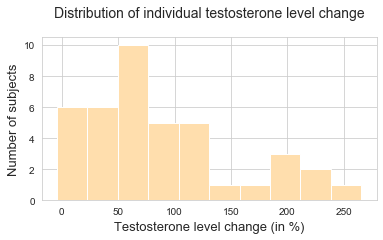

In [132]:
plt.hist(100*m_df[m_df['Test']==1].groupby('ID')['TPl_change'].mean(), color = 'navajowhite', density=False); 
plt.title('Distribution of individual testosterone level change', size = 14, pad=20);
plt.xlabel('Testosterone level change (in %)', size = 13);
plt.ylabel('Number of subjects', size = 13);

## Exploratory data analysis

In [127]:
p = list(win_money.keys())
#gain  = [win_money[ps]['A']*p - win_money[ps]['B'] for ps in p ]
[win_money[ps]['A']*ps - win_money[ps]['B']  for ps in p ]
p

[0.9, 0.7, 0.5, 0.3, 0.1]

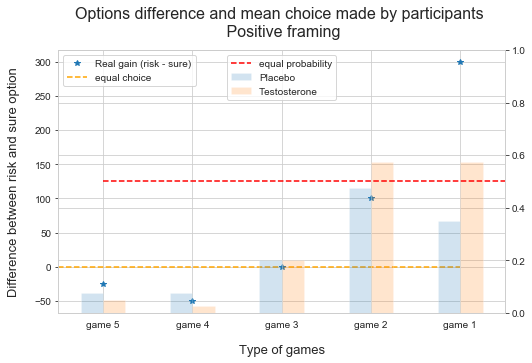

In [145]:
choiceP_T = m_df[(m_df['Win']==1)&((m_df['Test']==1))].groupby(['P'])['Strategy'].mean()
choiceP_Pl = m_df[(m_df['Win']==1)&((m_df['Test']==0))].groupby(['P'])['Strategy'].mean()

fig, ax1 = plt.subplots(figsize = (8,5))
fig.subplots_adjust(bottom=0.15)
p = list(win_money.keys())
lines = ax1.plot(p,[win_money[ps]['A']*ps - win_money[ps]['B']  for ps in p ],'*', label = 'Real gain (risk - sure)');
#ax1.legend(lines, ['Real gain (risk - sure)'] , loc='upper left')
ax1.set_xticks([0.1,0.3,0.5,0.7, 0.9])
ax1.hlines(0, 0,0.9, 'orange',linestyle='dashed',label=f"equal choice")
ax1.legend()
ax1.set_xlim(0,1)
ax1.set_xticklabels(['game 5','game 4','game 3','game 2', 'game 1'])
ax1.set_ylabel('Difference between risk and sure option', size= 13, labelpad=15);
ax1.set_xlabel('Type of games',size= 13, labelpad=15);
ax2 = ax1.twinx() 
plc = ax2.bar(choiceP_Pl.index, choiceP_Pl, width = -0.05, align='edge', alpha = 0.2, label = 'Placebo'); ax2.set_ylim((0,1));
horm = ax2.bar(choiceP_T.index, choiceP_T, width = 0.05, align='edge', alpha = 0.2, label = 'Testosterone'); ax2.set_ylim((0,1));
ax2.hlines(0.5, 0.1,1, 'red',linestyle='dashed',label=f"equal probability")
ax2.legend(loc = 'upper center');
plt.title(f'Options difference and mean choice made by participants \n Positive framing', size =16, pad = 14);


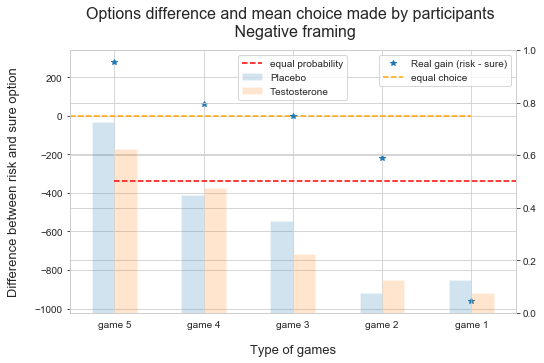

In [146]:
choiceP_T = m_df[(m_df['Win']==0)&((m_df['Test']==1))].groupby(['P'])['Strategy'].mean()
choiceP_Pl = m_df[(m_df['Win']==0)&((m_df['Test']==0))].groupby(['P'])['Strategy'].mean()

fig, ax1 = plt.subplots(figsize = (8,5))
fig.subplots_adjust(bottom=0.15)
p = list(loss_money.keys())
lines = ax1.plot(p,[-loss_money[ps]['A']*ps + loss_money[ps]['B']  for ps in p ],'*', label = 'Real gain (risk - sure)');
#ax1.legend(lines, ['Real gain (risk - sure)'] , loc='upper left')
ax1.set_xticks([0.1,0.3,0.5,0.7, 0.9])
ax1.set_xlim(0,1)
ax1.hlines(0, 0,0.9, 'orange',linestyle='dashed',label=f"equal choice")
ax1.legend()
ax1.set_xticklabels(['game 5','game 4','game 3','game 2', 'game 1'])
ax1.set_ylabel('Difference between risk and sure option', size= 13, labelpad=15);
ax1.set_xlabel('Type of games',size= 13, labelpad=15);
ax2 = ax1.twinx() 
plc = ax2.bar(choiceP_Pl.index, choiceP_Pl, width = -0.05, align='edge', alpha = 0.2, label = 'Placebo'); ax2.set_ylim((0,1));
horm = ax2.bar(choiceP_T.index, choiceP_T, width = 0.05, align='edge', alpha = 0.2, label = 'Testosterone'); ax2.set_ylim((0,1));
ax2.hlines(0.5, 0.1,1, 'red',linestyle='dashed',label=f"equal probability")
ax2.legend(loc = 'upper center');
plt.title(f'Options difference and mean choice made by participants \n Negative framing', size =16, pad = 14);


## Utility function for gap estimation
From cpt theory: theano version for pyMC3 estimation


In [62]:
def value_f(x, alpha):
    """
    the power value function suggested by Tversky and Kahneman (1992)
    @param x: float, positive, money
    @param alpha: float, expected to be less then 1     
    """
    #val = tt.switch(tt.lt(x, 0),-tt.pow(-x, alpha),tt.pow(x, alpha))
    val  = tt.sgn(x)*tt.pow(tt.abs_(x),alpha)
    return val


def weights(p,c):
    """
    one-parameter weighting function used in Nilsson  
    @param p: float, real probability of gain or loss, should be in the interval (0,1) 
    @param c: float,the elevation of the weighting function, should be positive, expected in the interval (0,5)     
    @return: float, subjective probability of gain or loss, should be in the interval (0,1) 
    """
    numer = tt.pow(p,c)
    denom = tt.pow(tt.pow(p,c) + tt.pow(1-p,c),1/c)
    return numer/denom

def weights_numpy(p,c):
    """
    one-parameter weighting function used in Nilsson
    
    @param p: float, real probability of gain or loss, should be in the interval (0,1) 
    @param c: float,the elevation of the weighting function, should be positive, expected in the interval (0,5) 
    @return: float, subjective probability of gain or loss, should be in the interval (0,1) 
    """
    numer = np.power(p,c)
    denom = np.power(np.power(p,c) + np.power(1-p,c),1/c)
    return numer/denom
def value_numpy(x,alpha):
    return np.sign(x)*np.abs(x)**alpha
def gap(A, B, p, alpha, c):
    """
    Here for loss we also have positive values, so need to multiply gap value to -1 later
    
    compute subjective difference between two options: A (game), B (sure)
    @param A: float, positive, money, risk value
    @param B: float, positive, money, sure option
    @param alpha: float, expected to be less then 1  
    """
    val = value_f(A, alpha)*weights(p,c) - value_f(B, alpha)
    return val

## Models estimation

For all models:

$$y_i \sim Binomial(1, p_i)$$

**Baseline models (without testosterone condition)**

As a baseline we etimated two models: 
 - model 0.1: the one from prospect theory without aprior information from replication study, where CPT parameters estimated from the data and without intercept
 
 
$$logit(p_i)  =  \beta_{F}*gap(A,B,\alpha_{F},c_{F})$$
where F is framing type
$$\alpha \sim BoundedNormal(\mu = 0.7, sd = 0.5, shape = 2)[0,1]$$
$$c \sim BoundedNormal(\mu = 0.7, sd = 0.5, shape = 2)[0,1]$$
$$\beta \sim BoundedNormal(\mu = 0.5, sd = 1, shape = 2)[0,\infty]$$

To satisfy non-negative condition for parameters all distribution were bounded 

 - model 0.2: with intercept and gap log transform
 
$$logit(p_i)  =  a_F+\beta_{F}*\log(gap(A,B,\alpha_{F},c_{F}))$$

$$a \sim Normal(\mu = 0, sd = 1, shape = 2)$$
$$\alpha \sim BoundedNormal(\mu = 0.7, sd = 0.5, shape = 2)[0,1]$$
$$c \sim BoundedNormal(\mu = 0.7, sd = 0.5, shape = 2)[0,1]$$
$$\beta \sim BoundedNormal(\mu = 0.5, sd = 1, shape = 2)[0,\infty]$$



 - model 1.7 (final): with intercept and gap log transform, individual differences. But maybe need to check covariance in varing 
 
 

$$\alpha_{cond} = Normal(0,1, shape = 2)$$

$$\beta_{cond} = BoundedNormal(0.4,0.5, shape = 2)$$

 - model 1: 4 conditions 0: Win(Placebo), 1: Win(Test),2: Loss(Placebo), 3: Loss(Test)
 
 $$y_i \sim Binomial(1, p_i)$$
$$\theta = logit(p_i)  = \alpha_{cond} + \beta_{cond}*gap(A,B,alpha,c)$$
$$\alpha_{cond} = Normal(0,1, shape = 4)$$

$$\beta_{cond} = BoundedNormal(0.4,0.5, shape = 4)$$


### Model evaluation functions

For model quality evaluation we used:
 - posterior predictive checks: how well model explain the same data from the model. In our case we used two scorings: roc_auc_score, and $R^2$ for regression between real choise and predictions at the group level 

 - WAIC (widely applicable information criterion) (the greater the better)

In [73]:
def est_model_group(trace, model, df=None):
    est_df = df.copy()   
    ppc = pm.sample_posterior_predictive(trace, samples=500, model=model)
    beta = st.beta((ppc['Strg'] == 1).sum(axis=0), (ppc['Strg'] == 0).sum(axis=0))
    est_df['Pred_lb'] = beta.interval(0.95)[0]
    est_df['Pred_ub'] = beta.interval(0.95)[1]
    est_df['Pred'] = ppc['Strg'].mean(axis=0)
    res = est_df.groupby('GameId')[['Pred','Strategy']].mean()

    res = est_df.groupby('GameId')[['Pred','Strategy', 'Pred_lb', 'Pred_ub']].mean()
    errs = (res['Pred_lb'].values.T,res['Pred_ub'].values.T)

    plt.plot(res.Strategy, res.Pred,'*',[0,1],[0,1]);
    plt.vlines(res.Strategy, *errs, colors='gray')
    
    regressor = LinearRegression(fit_intercept=False)
    regressor.fit(res.Strategy.values.reshape(-1,1), res.Pred.values.reshape(-1,1))
    print(f'R^2 value for real and predicted data: {regressor.score(res.Strategy.values.reshape(-1,1), res.Pred.values.reshape(-1,1)):.2f}')
    score = roc_auc_score(m_df.Strategy, ppc['Strg'].mean(axis = 0))
    print(f'ROC_AUC score for real and predicted data: {score:.2f}')

    #plt.show()
    return est_df

### Model 0.1: Original CPT model without shift and without logarithmic transform

without hormone difference

$$logit(p_i)  =  \beta_{F}*gap(A,B,\alpha_{F},c_{F})$$
where F is framing type
$$\alpha \sim BoundedNormal(\mu = 0.7, sd = 0.5, shape = 2)[0,1]$$
$$c \sim BoundedNormal(\mu = 0.7, sd = 0.5, shape = 2)[0,1]$$
$$\beta \sim BoundedNormal(\mu = 0.5, sd = 1, shape = 2)[0,\infty]$$

In [147]:
m_df.head()

,ID,Strategy,Test,Win,P,A,B,Inds,GameId,TypeCode,TPl_change
0,PK01,1,1,1,0.9,2000,1500,24,19,1,0.764706
1,PK02,1,1,1,0.9,2000,1500,25,19,1,1.271429
2,PK03,1,1,1,0.9,2000,1500,26,19,1,0.872000
3,PK04,1,1,1,0.9,2000,1500,27,19,1,1.929293
4,PK05,0,1,1,0.9,2000,1500,28,19,1,1.634146


In [72]:
chains = 4
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_01:
    """
    model without any individual distinctions, without testosterone. Estimation CPT model from the data
    """    
    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = BoundedNormalI('alpha',mu = 0.7, sd=0.5, shape = 2)
    c = BoundedNormalI('c', mu = 0.7, sd = 0.5, shape = 2)
    beta = BoundedNormal('beta', 0.5,1, shape = 2)

    Gap = gap(m_df.A, m_df.B, m_df.P, alpha[m_df.Win.values], c[m_df.Win.values]) 

    theta = pm.math.invlogit(beta[m_df.Win.values]*Gap)
   
    strategy = pm.Bernoulli("Strg", p=theta, observed=m_df.Strategy)

    trace_01 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]
 

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 486.53:   8%|▊         | 16525/200000 [00:09<01:45, 1737.87it/s]
Convergence achieved at 16600
Interrupted at 16,599 [8%]: Average Loss = 1,109.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, c, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:31<00:00, 321.59draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [74]:
az.waic(trace_01, scale = 'log')

Computed from 6000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -424.87    13.98
p_waic        3.89        -

In [75]:
az.summary(trace_0,credible_interval=.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.97,0.03,0.93,1.00,0.00,0.00,3932.04,3888.96,2953.60,2243.17,1.0
alpha[1],0.35,0.09,0.20,0.48,0.00,0.00,786.23,786.23,826.82,951.51,1.0
c[0],0.88,0.07,0.79,1.00,0.00,0.00,3597.59,3386.93,3012.69,1971.50,1.0
c[1],0.95,0.04,0.90,1.00,0.00,0.00,2450.55,2414.89,1925.83,1657.71,1.0
beta[0],0.00,0.00,0.00,0.01,0.00,0.00,4412.17,4412.17,4101.94,4685.20,1.0
beta[1],0.62,0.28,0.25,0.97,0.01,0.01,718.51,679.52,842.08,917.49,1.0


In negative framing sensitivity equal to 0, what means random guess

/Users/irinaknyazeva/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:02<00:00, 204.61it/s]


R^2 value for real and predicted data: 0.62
ROC_AUC score for real and predicted data: 0.75


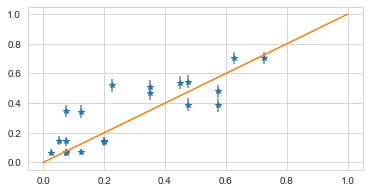

In [76]:
est = est_model_group(trace_01, model_01, m_df);

Low R^2, model slightly better then random guess

### Model 0.2: CPT model with shift and logarithmic transform 
without hormone difference

 
$$logit(p_i)  =  a_F+\beta_{F}*\log(gap(A,B,\alpha_{F},c_{F}))$$

$$a \sim Normal(\mu = 0, sd = 1, shape = 2)$$
$$\alpha \sim BoundedNormal(\mu = 0.7, sd = 0.5, shape = 2)[0,1]$$
$$c \sim BoundedNormal(\mu = 0.7, sd = 0.5, shape = 2)[0,1]$$
$$\beta \sim BoundedNormal(\mu = 0.5, sd = 1, shape = 2)[0,\infty]$$

In [80]:
chains = 4
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_02:
    """
    model without any individual distinctions, without testosterone
    """
    
    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    alpha = BoundedNormalI('alpha',mu = 0.7, sd=0.5, shape = 2)
    c = BoundedNormalI('c', mu = 0.7, sd = 0.5, shape = 2)
    beta = BoundedNormal('beta', mu = 0.5,sd = 1, shape = 2)
    a = pm.Normal('a', 0, 1, shape = 2)
    

    Gap = gap(m_df.A, m_df.B, m_df.P, alpha[m_df.Win.values], c[m_df.Win.values]) #[m_df.Win.values]
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta = pm.math.invlogit(a[m_df.Win.values]+beta[m_df.Win.values]*Gap)
   
    strategy = pm.Bernoulli("Strg", p=theta, observed=m_df.Strategy)
    trace_02 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 432.77:   8%|▊         | 16114/200000 [00:11<02:15, 1360.58it/s]
Convergence achieved at 16200
Interrupted at 16,199 [8%]: Average Loss = 509.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, c, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [02:33<00:00, 65.20draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [85]:
az.waic(trace_02, scale = 'log')

Computed from 6000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -407.27    14.42
p_waic        5.99        -

In [86]:
az.compare({'model01': trace_01, 'model02': trace_02})

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model02,0,814.542,5.99237,0,0.997978,27.4851,0,False,deviance
model01,1,849.745,3.88947,35.2029,0.00202209,28.2406,11.2177,False,deviance


In [87]:
az.summary(trace_02,credible_interval=.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.41,0.65,-2.48,-0.70,0.05,0.03,187.60,187.60,243.22,1233.69,1.02
a[1],-0.74,0.82,-1.65,0.74,0.07,0.05,142.34,142.34,238.75,637.38,1.02
alpha[0],0.70,0.32,0.23,1.00,0.03,0.02,153.60,153.60,197.47,1271.85,1.02
alpha[1],0.76,0.22,0.41,1.00,0.02,0.01,176.52,176.52,238.07,415.39,1.03
c[0],0.91,0.08,0.80,1.00,0.00,0.00,1661.17,1661.17,1601.67,2639.24,1.00
c[1],0.90,0.08,0.79,1.00,0.00,0.00,1105.24,1068.23,954.80,879.12,1.00
beta[0],0.71,0.72,0.16,1.88,0.05,0.04,187.38,187.38,209.58,1338.36,1.02
beta[1],0.63,0.63,0.20,1.63,0.05,0.04,141.93,141.93,239.19,474.02,1.02


/Users/irinaknyazeva/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:02<00:00, 239.08it/s]


R^2 value for real and predicted data: 0.83
ROC_AUC score for real and predicted data: 0.77


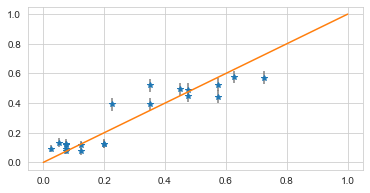

In [88]:
est = est_model_group(trace_02, model_1, m_df);

### Model 1:  with fixed alpha and c from replication study

Final model with fixed alpha and c, individual differences and testosterone 

To prevent overfitting, we estimated the log gap model from the other data  
From replication study  (see notebook Rieksamp_replication.ipynb)


$$\alpha = 0.756 \pm 0.033$$  
$$c = 0.794 \pm 0.022 $$



$$logit(p_i)  =  A + B*\log(gap(A,B,\alpha,c))$$
$$A = a_{ind}+a_{F}+ delta\_a_{F}*TPL\_change$$
$$B = b_{ind}+b_{F}+ delta\_b_{F}*TPL\_change$$

where F is framing type, ind - individual index

$$\alpha= 0.75, c = 0.8$$


$$a_{F} \sim Normal(\mu = 0, sd = 1, shape = 2)$$
$$a_{ind} \sim Normal(\mu = 0, sd = 1, shape = 40)$$
$$delta\_a{_F} \sim Normal(\mu = 0, sd = 0.5, shape = 2)$$


$$delta\_b{_F} \sim Normal(\mu = 0, sd = 0.5, shape = 2)$$
$$b \sim Normal(\mu = 0.5, sd = 0.5, shape = 2)$$
$$b_{ind} \sim Normal(\mu = 0, sd = 0.5, shape = N)$$



In [90]:
chains = 2
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_17:
    """
    model without any individual distinctions, with hormones
    """
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = 0.75
    c = 0.8
    a = pm.Normal('a', 0, 1, shape = 2)
    beta = BoundedNormal('beta', 0.5,0.5, shape = 2)
    delta_a = pm.Normal('delta_a', 0, 0.5, shape = 2)
    delta_b = pm.Normal('delta_b', 0, 0.5, shape = 2)

    alpha_ind = pm.Normal('alpha_ind', 0, 0.5,shape = N)
    beta_ind = pm.Normal('beta_ind', 0, 0.2, shape = N)
    

    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta_lin = alpha_ind[m_df.Inds.values]+a[m_df.Win.values]+delta_a[m_df.Win.values]*m_df.TPl_change.values+\
                (beta_ind[m_df.Inds.values]+ beta[m_df.Win.values]+delta_b[m_df.Win.values]*m_df.TPl_change.values)*Gap

    theta = pm.math.invlogit(theta_lin)


    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    #strategy = pm.Bernoulli("Strg", p=theta, observed=m_df.Strategy)

    trace_17 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 386.31:   7%|▋         | 14786/200000 [00:08<01:43, 1793.43it/s]
Convergence achieved at 14900
Interrupted at 14,899 [7%]: Average Loss = 551.87
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta_ind, alpha_ind, delta_b, delta_a, beta, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 446.58draws/s]


/Users/irinaknyazeva/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 279.00it/s]


R^2 value for real and predicted data: 0.80
ROC_AUC score for real and predicted data: 0.88


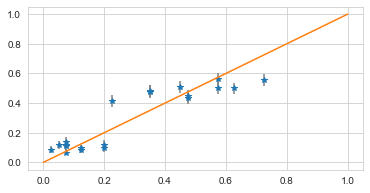

In [91]:
est = est_model_group(trace_17, model_17, m_df);

In [92]:
az.compare({'model01': trace_01, 'model02': trace_02, 'model17': trace_17})

/Users/irinaknyazeva/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model17,0,702.73,36.5301,0,1,29.1421,0,True,deviance
model02,1,814.542,5.99237,111.812,2.59831e-18,29.7073,16.0469,False,deviance
model01,2,849.745,3.88947,147.014,1.0452e-22,29.8881,19.6949,False,deviance


In [93]:
def plot_deltas(trace):

    fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
    for i in [0,1]:
        az.plot_posterior(trace['delta_a'][:, i], ref_val=0, ax = ax[i])
    fig.suptitle(f" Testosterone-related sure-option shift for Negative framing (left) and Positive (right)", fontsize=16);
    fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
    for i in [0,1]:
        az.plot_posterior(trace['delta_b'][:, i], ref_val=0, ax = ax[i])
    fig.suptitle(f" Testosterone-related sensitivity to gap for Negative framing (left) and Positive (right)", fontsize=16);
    
def plot_4cond(trace):   
    
    az.plot_forest(trace, var_names = ['a'], kind = 'ridgeplot', figsize=(4,5), colors='purple', ridgeplot_overlap=3);
    az.plot_forest(trace, var_names = ['beta'], kind = 'ridgeplot', figsize=(4,5), colors='#eeefff', ridgeplot_overlap=3);

## Testosterone-related parameters 

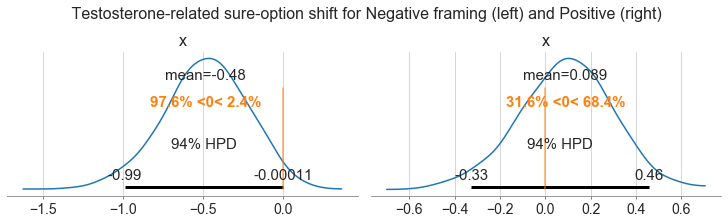

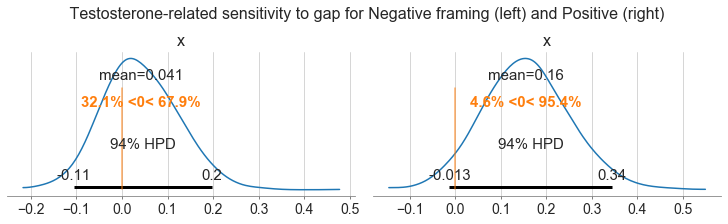

In [94]:
plot_deltas(trace_17)

## Effects analysis

In [155]:
gaps = list(np.log1p([1,15]))
gaps

[0.6931471805599453, 2.772588722239781]

In [163]:
def risk_sens_testn(trace, tchange = np.linspace(0,3,30), cr_int = 0.5, gaps = [1,15,150]):
    gaps = list(np.log1p(gaps))
    plt.figure(figsize = (15,6))

    #ind = 0 (Negative),1 (Positive)
    a_mu = trace['a'].mean(axis=0)
    a_bounds = az.hpd(trace['a'], credible_interval=cr_int)
    beta_mu = trace['beta'].mean(axis=0)
    beta_bounds = az.hpd(trace['beta'],credible_interval=cr_int)
    delta_a_mu = trace['delta_a'].mean(axis=0)
    delta_a_bounds = az.hpd(trace['delta_a'],credible_interval=cr_int)
    delta_b_mu = trace['delta_b'].mean(axis=0)
    delta_b_bounds = az.hpd(trace['delta_b'],credible_interval=cr_int)
    
    def theta_errs(ind, gap):
        theta = invlogit(a_mu[ind]+delta_a_mu[ind]*tchange+(beta_mu[ind]+delta_b_mu[ind]*tchange)*gap)
        theta_lb = invlogit(a_bounds[ind,0]+delta_a_bounds[ind,0]*tchange+(delta_b_bounds[ind,0]*tchange+beta_bounds[ind,0])*gap)
        theta_ub = invlogit(a_bounds[ind,1]+delta_a_bounds[ind,1]*tchange+(delta_b_bounds[ind,1]*tchange+beta_bounds[ind,1])*gap)
        return theta, theta_lb, theta_ub

    plt.suptitle(f'Willingness to risk depending on the testosteron level and potenial gain', fontsize = 20)

    colors=cm.plasma(np.linspace(0,0.6,len(gaps)))

    plt.subplot(1,2,1); 
    for gap, c in zip(gaps,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(1,gap)
        plt.plot(tchange, theta_W, color=c, label = f'Gain: {np.expm1(gap):.0f}'); plt.ylim(0,1); plt.legend()
        plt.vlines(tchange, theta_W_lb,theta_W_ub, colors = c, alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Change in testosterone level compared to placebo states')
    plt.title('Positive framing', size = 16)
    plt.ylim(-0.1,1.1)
    plt.legend()
    
    
    plt.subplot(1,2,2); 
    for gap, c in zip(gaps,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(0,gap)
        plt.plot(tchange, theta_W, label = f'Gain: {gap:.0f}', color=c); plt.ylim(0,1); plt.legend()
        plt.vlines(tchange, theta_W_lb,theta_W_ub, colors=c,alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Change iin testosterone level compared to placebo states')
    plt.title('Negative framing', size = 16)
    plt.ylim(-0.1,1.1)

    plt.legend()
    return theta_W, theta_W_lb, theta_W_ub

In [152]:
np.expm1(2), np.log1p(6.38), 300**0.8

(6.38905609893065, 1.998773638612381, 95.87315155141829)

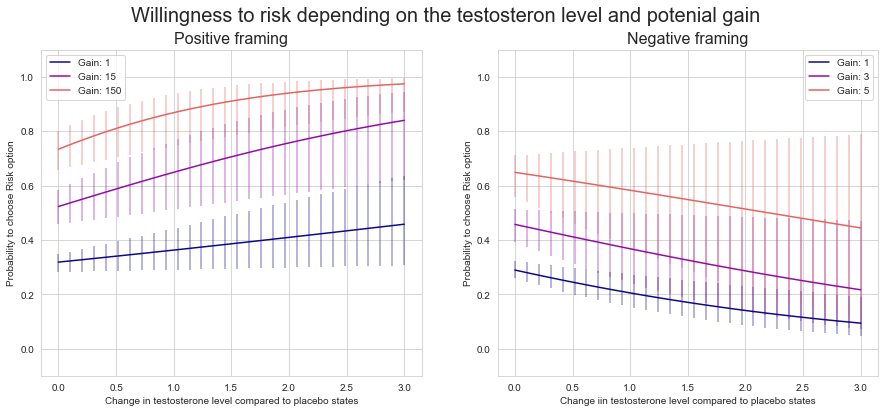

In [164]:
theta_W, theta_W_lb, theta_W_ub = risk_sens_testn(trace_17)

In [97]:
def gap_sens_testn(trace, gaps = np.linspace(0,5,50), cr_int = 0.5, testn = [0,0.6,1.5]):
    plt.figure(figsize = (15,6))

    a_mu = trace['a'].mean(axis=0)
    a_bounds = az.hpd(trace['a'], credible_interval=cr_int)
    beta_mu = trace['beta'].mean(axis=0)
    beta_bounds = az.hpd(trace['beta'],credible_interval=cr_int)
    delta_a_mu = trace['delta_a'].mean(axis=0)
    delta_a_bounds = az.hpd(trace['delta_a'],credible_interval=cr_int)
    delta_b_mu = trace['delta_b'].mean(axis=0)
    delta_b_bounds = az.hpd(trace['delta_b'],credible_interval=cr_int)
    
    def theta_errs(ind, test):
        theta = invlogit(a_mu[ind]+delta_a_mu[ind]*test+(beta_mu[ind]+delta_b_mu[ind]*test)*gaps)
        theta_lb = invlogit(a_bounds[ind,0]+delta_a_bounds[ind,0]*test+(delta_b_bounds[ind,0]*test+beta_bounds[ind,0])*gaps)
        theta_ub = invlogit(a_bounds[ind,1]+delta_a_bounds[ind,1]*test+(delta_b_bounds[ind,1]*test+beta_bounds[ind,1])*gaps)
        return theta, theta_lb, theta_ub

    plt.suptitle(f'Willingness to risk depending on the testosteron level and potential gain', fontsize = 20)

    colors=cm.plasma(np.linspace(0,0.6,len(testn)))

    plt.subplot(1,2,1); 
    for test, c in zip(testn,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(1,test)
        plt.plot(np.expm1(gaps), theta_W, color=c, label = f'ChangeTest: {100*test:.0f}'); plt.ylim(0,1); plt.legend()
        plt.vlines(np.expm1(gaps), theta_W_lb,theta_W_ub, colors = c, alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Change in testosterone level compared to placebo states')
    plt.title('Positive framing', size = 16)
    plt.legend()
    
    
    plt.subplot(1,2,2); 
    for test, c in zip(testn,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(0,test)
        plt.plot(np.expm1(gaps), theta_W, label = f'ChangeTest: {100*test:.0f}', color=c); plt.ylim(0,1); plt.legend()
        plt.vlines(np.expm1(gaps), theta_W_lb,theta_W_ub, colors=c,alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Change in testosterone level compared to placebo states')
    plt.title('Negative framing', size = 16)
    plt.legend()


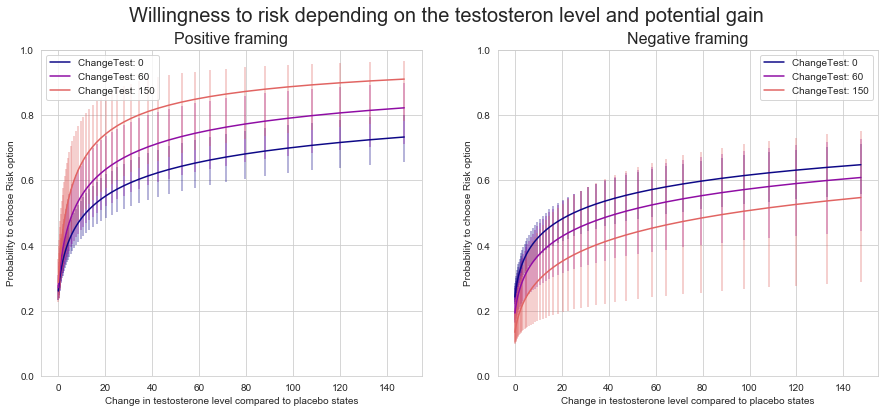

In [98]:
gap_sens_testn(trace_17)

In [15]:
chains = 4

with pm.Model() as model_2:
    """
    model without any individual distinctions, without testosterone
    """
    #try with fixed value of alpha
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = 0.75
    c = 0.8
    
    beta = BoundedNormal('beta', 0.5,1, shape = 2)
    a = pm.Normal('a', 0, 1, shape = 2)
    
    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta = pm.math.invlogit(a[m_df.Win.values]+beta[m_df.Win.values]*Gap)
   
    strategy = pm.Bernoulli("Strg", p=theta, observed=m_df.Strategy)
    trace_2 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 420.62:   5%|▌         | 10099/200000 [00:02<00:53, 3552.09it/s]
Convergence achieved at 10100
Interrupted at 10,099 [5%]: Average Loss = 522.61
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:03<00:00, 2986.70draws/s]


/opt/anaconda3/envs/ML/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 496.67it/s]


R^2 value for real and predicted data: 0.76
ROC_AUC score for real and predicted data: 0.76


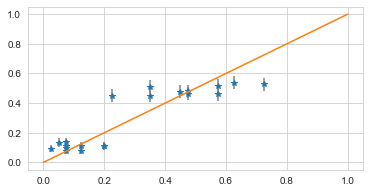

In [16]:
est = est_model_group(trace_2, model_2, m_df);

In [17]:
az.waic(trace_2)

Computed from 6000 by 800 log-likelihood matrix

        Estimate       SE
IC_waic   820.90    29.07
p_waic      4.03        -

In [18]:
az.summary(trace_2,credible_interval=.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.15,0.15,-1.38,-0.92,0.0,0.0,3901.61,3796.75,3977.96,3830.15,1.0
a[1],-0.90,0.13,-1.10,-0.69,0.0,0.0,5790.25,5703.00,5808.62,4240.54,1.0
beta[0],0.31,0.04,0.25,0.37,0.0,0.0,3694.40,3681.19,3698.30,3950.69,1.0
beta[1],0.42,0.05,0.33,0.50,0.0,0.0,5505.35,5505.35,5504.86,3918.81,1.0


### Model 3:  with fixed alpha and c from replication study, and 4 conditions

In [19]:
chains = 2
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_3:
    """
    model without any individual distinctions, with hormones
    """
    #try with fixed value of alpha
    
    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = 0.75
    c = 0.8

    a = pm.Normal('a', 0, 1, shape = 4)
    beta = BoundedNormal('beta', 0.5,0.5, shape = 4)
    
    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta = pm.math.invlogit(a[m_df.TypeCode.values]+beta[m_df.TypeCode.values]*Gap)
   
    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    trace_3 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 424.22:   5%|▍         | 9199/200000 [00:02<00:54, 3530.98it/s]
Convergence achieved at 9200
Interrupted at 9,199 [4%]: Average Loss = 534.01
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:04<00:00, 1164.06draws/s]


In [20]:
az.waic(trace_3)

Computed from 3000 by 800 log-likelihood matrix

        Estimate       SE
IC_waic   823.04    29.68
p_waic      8.06        -

In [21]:
az.summary(trace_3, credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.03,0.18,-1.23,-0.82,0.0,0.0,3069.74,2891.56,3057.51,2030.24,1.0
a[1],-0.77,0.18,-0.97,-0.56,0.0,0.0,2711.95,2422.19,2780.83,2089.09,1.0
a[2],-1.07,0.21,-1.28,-0.81,0.0,0.0,2274.91,2188.38,2291.20,1992.22,1.0
a[3],-1.22,0.21,-1.47,-0.98,0.0,0.0,1943.76,1912.74,1954.95,1937.85,1.0
beta[0],0.33,0.07,0.26,0.42,0.0,0.0,2935.41,2935.41,2863.09,1698.08,1.0
beta[1],0.52,0.08,0.43,0.60,0.0,0.0,3050.71,2992.90,2995.38,2157.31,1.0
beta[2],0.32,0.06,0.25,0.38,0.0,0.0,2041.87,2041.87,2002.10,2096.24,1.0
beta[3],0.29,0.06,0.23,0.36,0.0,0.0,1776.44,1776.44,1754.37,1929.09,1.0


/opt/anaconda3/envs/ML/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 1247.61it/s]


R^2 value for real and predicted data: 0.82
ROC_AUC score for real and predicted data: 0.77


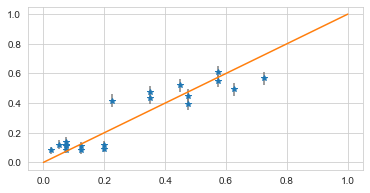

In [22]:
est = est_model_group(trace_3, model_3, m_df);

### Model 4: reparametrization: additional testosterone effect
The same model as previous, but parameterized with additional effect of testosterone

In [23]:
chains = 2
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_4:
    """
    model without any individual distinctions, with hormones
    """
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = 0.75
    c = 0.8

    a = pm.Normal('a', 0, 1, shape = 2)
    beta = BoundedNormal('beta', 0.5,0.5, shape = 2)
    delta_a = pm.Normal('delta_a', 0, 0.5, shape = 2)
    delta_b = pm.Normal('delta_b', 0, 0.5, shape = 2)

    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    theta_lin = a[m_df.Win.values]+delta_a[m_df.Win.values]*m_df.Test.values+(beta[m_df.Win.values]+delta_b[m_df.Win.values]*m_df.Test.values)*Gap
    
    theta = pm.math.invlogit(theta_lin)
   
    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    trace_4 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 422.16:   7%|▋         | 14499/200000 [00:04<01:00, 3061.84it/s]
Convergence achieved at 14500
Interrupted at 14,499 [7%]: Average Loss = 516.53
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [delta_b, delta_a, beta, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:07<00:00, 671.51draws/s]


In [24]:
az.waic(trace_4)

Computed from 3000 by 800 log-likelihood matrix

        Estimate       SE
IC_waic   822.37    29.79
p_waic      7.71        -

In [25]:
az.summary(trace_4,credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.09,0.20,-1.29,-0.84,0.01,0.0,1341.37,1299.54,1356.73,1448.78,1.0
a[1],-1.01,0.17,-1.20,-0.81,0.00,0.0,1907.18,1793.25,1909.29,1571.45,1.0
delta_a[0],-0.15,0.26,-0.42,0.19,0.01,0.0,1455.99,1455.99,1456.29,1947.55,1.0
delta_a[1],0.20,0.23,-0.07,0.45,0.01,0.0,1998.28,1315.10,2020.63,1589.79,1.0
delta_b[0],-0.03,0.08,-0.13,0.05,0.00,0.0,1482.75,1419.41,1484.82,1439.10,1.0
delta_b[1],0.18,0.10,0.07,0.31,0.00,0.0,2432.11,2077.80,2439.17,2183.68,1.0
beta[0],0.33,0.06,0.25,0.38,0.00,0.0,1432.48,1424.92,1429.19,1635.40,1.0
beta[1],0.33,0.07,0.25,0.41,0.00,0.0,2179.96,2179.96,2155.92,1708.28,1.0


/opt/anaconda3/envs/ML/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 422.47it/s]


R^2 value for real and predicted data: 0.81
ROC_AUC score for real and predicted data: 0.76


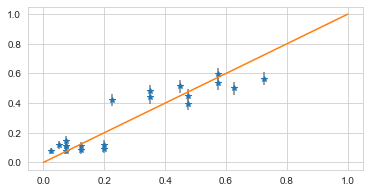

In [26]:
est = est_model_group(trace_4, model_4, m_df);

### Model 5. Modification with the level of percentage changes

In [27]:
chains = 2
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_5:
    """
    model without any individual distinctions, with hormones
    """
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = 0.75
    c = 0.8

    a = pm.Normal('a', 0, 1, shape = 2)
    beta = BoundedNormal('beta', 0.5,0.5, shape = 2)
    delta_a = pm.Normal('delta_a', 0, 0.5, shape = 2)
    delta_b = pm.Normal('delta_b', 0, 0.5, shape = 2)

 
    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    theta_lin = a[m_df.Win.values]+delta_a[m_df.Win.values]*m_df.TPl_change.values+(beta[m_df.Win.values]+delta_b[m_df.Win.values]*m_df.TPl_change.values)*Gap
    
    theta = pm.math.invlogit(theta_lin)
   
    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    trace_5 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 421.26:   7%|▋         | 14299/200000 [00:04<01:01, 3029.51it/s]
Convergence achieved at 14300
Interrupted at 14,299 [7%]: Average Loss = 522.66
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [delta_b, delta_a, beta, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:06<00:00, 731.26draws/s]


In [28]:
az.waic(trace_5)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 3000 by 800 log-likelihood matrix

        Estimate       SE
IC_waic   820.23    29.55
p_waic      7.56        -

There has been a warning during the calculation. Please check the results.

In [29]:
az.summary(trace_5,credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.98,0.17,-1.18,-0.79,0.00,0.0,1568.87,1515.87,1594.50,1472.69,1.0
a[1],-0.93,0.15,-1.09,-0.76,0.00,0.0,2645.73,2438.79,2687.46,1994.47,1.0
delta_a[0],-0.49,0.25,-0.75,-0.17,0.01,0.0,1612.72,1524.12,1645.11,1775.41,1.0
delta_a[1],0.03,0.19,-0.18,0.26,0.00,0.0,2307.23,1284.67,2332.60,1971.77,1.0
delta_b[0],0.06,0.08,-0.04,0.13,0.00,0.0,1720.15,1582.98,1740.05,1861.20,1.0
delta_b[1],0.15,0.09,0.05,0.25,0.00,0.0,2262.93,2038.04,2281.60,2124.63,1.0
beta[0],0.30,0.05,0.24,0.35,0.00,0.0,1661.26,1661.26,1650.02,1579.07,1.0
beta[1],0.36,0.06,0.29,0.43,0.00,0.0,2482.59,2482.59,2465.44,1977.16,1.0


### Model 6: Four condition model and individual differences

In [30]:
chains = 2
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_6:
    """
    model without any individual distinctions, with hormones
    """
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = 0.75
    c = 0.8
    a = pm.Normal('a', 0, 1, shape = 4)
    beta = BoundedNormal('beta', 0.5,0.5, shape = 4)
    alpha_ind = pm.Normal('alpha_ind', 0, 0.5,shape = 40)
    beta_ind = pm.Normal('beta_ind', 0, 0.2, shape = 40)
    

    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta = pm.math.invlogit(alpha_ind[m_df.Inds.values]+a[m_df.TypeCode.values]+(beta_ind[m_df.Inds.values]+beta[m_df.TypeCode.values])*Gap)

    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    #strategy = pm.Bernoulli("Strg", p=theta, observed=m_df.Strategy)

    trace_6 = pm.sample(5000, tune=1000, target_accept=0.95, chains=chains, init = 'advi')[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 389.21:   6%|▌         | 11899/200000 [00:03<00:59, 3151.56it/s]
Convergence achieved at 11900
Interrupted at 11,899 [5%]: Average Loss = 553.92
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta_ind, alpha_ind, beta, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:17<00:00, 689.07draws/s]


In [31]:
az.waic(trace_6)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 8000 by 800 log-likelihood matrix

        Estimate       SE
IC_waic   705.18    29.17
p_waic     37.20        -

There has been a warning during the calculation. Please check the results.

In [32]:
az.summary(trace_6, var_names = ['a','beta'],credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.13,0.20,-1.35,-0.89,0.0,0.0,8770.11,8485.85,8777.85,6192.11,1.0
a[1],-0.81,0.21,-1.03,-0.55,0.0,0.0,9215.08,8294.62,9252.14,5859.54,1.0
a[2],-1.17,0.23,-1.43,-0.91,0.0,0.0,6352.12,6128.01,6413.68,5999.65,1.0
a[3],-1.36,0.23,-1.61,-1.07,0.0,0.0,6753.81,6435.59,6864.57,6162.79,1.0
beta[0],0.37,0.08,0.27,0.46,0.0,0.0,6537.63,6537.63,6452.00,4086.55,1.0
beta[1],0.58,0.09,0.48,0.68,0.0,0.0,8075.65,8075.65,7993.95,5219.32,1.0
beta[2],0.37,0.07,0.29,0.45,0.0,0.0,4930.76,4930.76,4908.49,4895.93,1.0
beta[3],0.34,0.07,0.25,0.41,0.0,0.0,4820.03,4820.03,4759.74,4230.71,1.0


/opt/anaconda3/envs/ML/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 399.10it/s]


R^2 value for real and predicted data: 0.81
ROC_AUC score for real and predicted data: 0.89


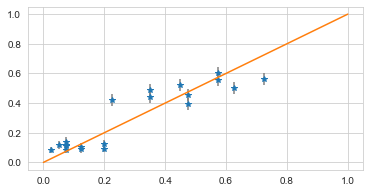

In [33]:
est = est_model_group(trace_6, model_6, m_df);

### Model 7: Individual differences and additional parameters for testosterone

In [34]:
chains = 2
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_7:
    """
    model without any individual distinctions, with hormones
    """
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = 0.75
    c = 0.8
    a = pm.Normal('a', 0, 1, shape = 2)
    beta = BoundedNormal('beta', 0.5,0.5, shape = 2)
    delta_a = pm.Normal('delta_a', 0, 0.5, shape = 2)
    delta_b = pm.Normal('delta_b', 0, 0.5, shape = 2)

    alpha_ind = pm.Normal('alpha_ind', 0, 0.5,shape = 40)
    beta_ind = pm.Normal('beta_ind', 0, 0.2, shape = 40)
    

    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta_lin = alpha_ind[m_df.Inds.values]+a[m_df.Win.values]+delta_a[m_df.Win.values]*m_df.TPl_change.values+\
                (beta_ind[m_df.Inds.values]+ beta[m_df.Win.values]+delta_b[m_df.Win.values]*m_df.TPl_change.values)*Gap

    theta = pm.math.invlogit(theta_lin)


    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    #strategy = pm.Bernoulli("Strg", p=theta, observed=m_df.Strategy)

    trace_7 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 386.53:   7%|▋         | 14799/200000 [00:05<01:08, 2689.77it/s]
Convergence achieved at 14800
Interrupted at 14,799 [7%]: Average Loss = 550.78
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta_ind, alpha_ind, delta_b, delta_a, beta, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:09<00:00, 534.85draws/s]


In [35]:
az.waic(trace_7)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 3000 by 800 log-likelihood matrix

        Estimate       SE
IC_waic   702.79    29.34
p_waic     36.43        -

There has been a warning during the calculation. Please check the results.

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 389.30it/s]


R^2 value for real and predicted data: 0.79
ROC_AUC score for real and predicted data: 0.89


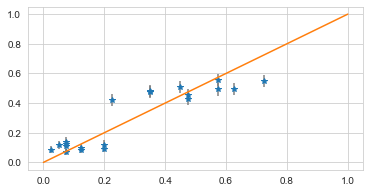

In [36]:
est = est_model_group(trace_7, model_7, m_df);

In [37]:
az.summary(trace_7, var_names = ['a','beta', 'delta_a','delta_b'],credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.14,0.19,-1.34,-0.90,0.00,0.0,1706.18,1706.18,1706.04,1974.86,1.0
a[1],-1.05,0.18,-1.25,-0.85,0.00,0.0,2122.54,2072.14,2128.44,2084.83,1.0
beta[0],0.35,0.06,0.28,0.41,0.00,0.0,1252.13,1252.13,1246.83,1407.27,1.0
beta[1],0.41,0.07,0.33,0.50,0.00,0.0,1897.96,1897.96,1912.28,1513.98,1.0
delta_a[0],-0.49,0.26,-0.76,-0.16,0.01,0.0,1781.19,1591.49,1826.84,1775.38,1.0
delta_a[1],0.08,0.22,-0.17,0.33,0.00,0.0,2640.64,1962.02,2648.86,2094.93,1.0
delta_b[0],0.04,0.08,-0.06,0.12,0.00,0.0,1700.34,1691.24,1708.08,1983.13,1.0
delta_b[1],0.16,0.10,0.04,0.26,0.00,0.0,2959.13,2279.49,3050.06,2288.07,1.0


## Testosterone-related parameters 

In [38]:
def plot_deltas(trace):

    fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
    for i in [0,1]:
        az.plot_posterior(trace['delta_a'][:, i], ref_val=0, ax = ax[i])
    fig.suptitle(f" Testosterone-related sure-option shift for Negative framing (left) and Positive (right)", fontsize=16);
    fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
    for i in [0,1]:
        az.plot_posterior(trace['delta_b'][:, i], ref_val=0, ax = ax[i])
    fig.suptitle(f" Testosterone-related sensitivity to gap for Negative framing (left) and Positive (right)", fontsize=16);
    
def plot_4cond(trace):   
    
    az.plot_forest(trace, var_names = ['a'], kind = 'ridgeplot', figsize=(4,5), colors='purple', ridgeplot_overlap=3);
    az.plot_forest(trace, var_names = ['beta'], kind = 'ridgeplot', figsize=(4,5), colors='#eeefff', ridgeplot_overlap=3);

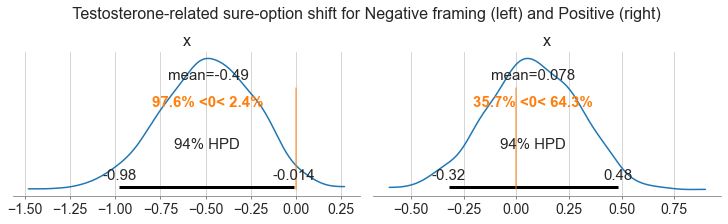

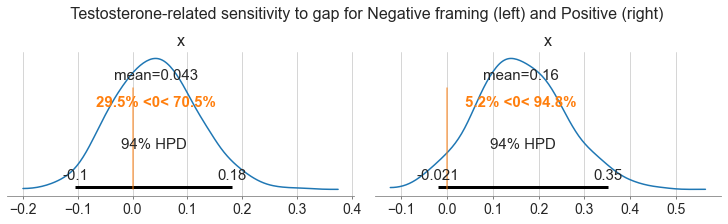

In [39]:
plot_deltas(trace_7)

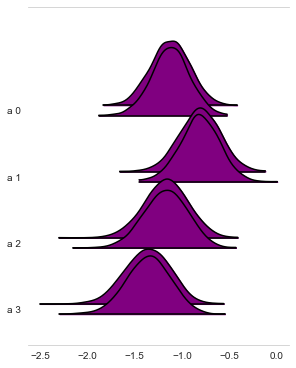

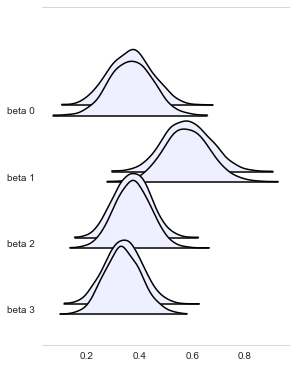

In [40]:
plot_4cond(trace_6)

## Effect analysis

### Risk sensitivity to the percentage change in testosterone level with the fixed gaps

In [41]:
def risk_sens_testn(trace, tchange = np.linspace(0,3,30), cr_int = 0.5, gaps = [1,3,5]):
    plt.figure(figsize = (15,6))

    #ind = 0 (Negative),1 (Positive)
    a_mu = trace['a'].mean(axis=0)
    a_bounds = az.hpd(trace['a'], credible_interval=cr_int)
    beta_mu = trace['beta'].mean(axis=0)
    beta_bounds = az.hpd(trace['beta'],credible_interval=cr_int)
    delta_a_mu = trace['delta_a'].mean(axis=0)
    delta_a_bounds = az.hpd(trace['delta_a'],credible_interval=cr_int)
    delta_b_mu = trace['delta_b'].mean(axis=0)
    delta_b_bounds = az.hpd(trace['delta_b'],credible_interval=cr_int)
    
    def theta_errs(ind, gap):
        theta = invlogit(a_mu[ind]+delta_a_mu[ind]*tchange+(beta_mu[ind]+delta_b_mu[ind]*tchange)*gap)
        theta_lb = invlogit(a_bounds[ind,0]+delta_a_bounds[ind,0]*tchange+(delta_b_bounds[ind,0]*tchange+beta_bounds[ind,0])*gap)
        theta_ub = invlogit(a_bounds[ind,1]+delta_a_bounds[ind,1]*tchange+(delta_b_bounds[ind,1]*tchange+beta_bounds[ind,1])*gap)
        return theta, theta_lb, theta_ub

    plt.suptitle(f'Willingness to risk depending on the testosteron level and potenial gain', fontsize = 20)

    colors=cm.plasma(np.linspace(0,0.6,len(gaps)))

    plt.subplot(1,2,1); 
    for gap, c in zip(gaps,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(1,gap)
        plt.plot(tchange, theta_W, color=c, label = f'Gain: {np.expm1(gap):.0f}'); plt.ylim(0,1); plt.legend()
        plt.vlines(tchange, theta_W_lb,theta_W_ub, colors = c, alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Change in testosterone level compared to placebo states')
    plt.title('Positive framing', size = 16)
    plt.legend()
    
    
    plt.subplot(1,2,2); 
    for gap, c in zip(gaps,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(0,gap)
        plt.plot(tchange, theta_W, label = f'Gain: {np.expm1(gap):.0f}', color=c); plt.ylim(0,1); plt.legend()
        plt.vlines(tchange, theta_W_lb,theta_W_ub, colors=c,alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Change iin testosterone level compared to placebo states')
    plt.title('Negative framing', size = 16)
    plt.legend()
    return theta_W, theta_W_lb, theta_W_ub

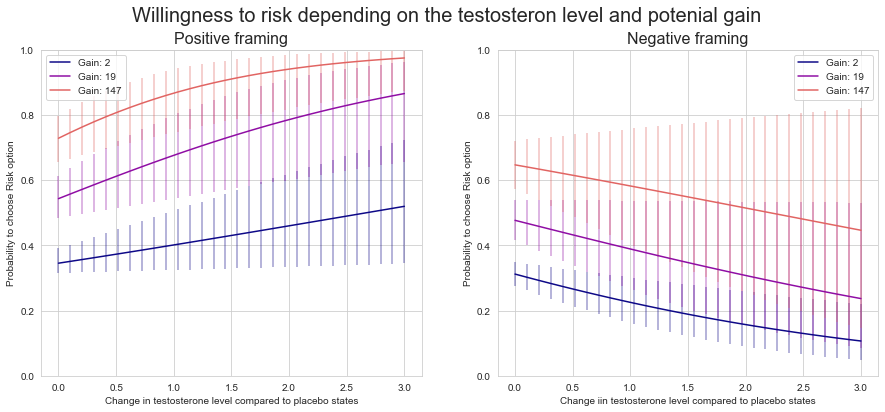

In [42]:
theta_W, theta_W_lb, theta_W_ub = risk_sens_testn(trace_7)

### Willingness to risk depending on the gap with several level of testosterone changes

In [43]:
def gap_sens_testn(trace, gaps = np.linspace(0,5,50), cr_int = 0.5, testn = [0,0.6,1.5]):
    plt.figure(figsize = (15,6))

    a_mu = trace['a'].mean(axis=0)
    a_bounds = az.hpd(trace['a'], credible_interval=cr_int)
    beta_mu = trace['beta'].mean(axis=0)
    beta_bounds = az.hpd(trace['beta'],credible_interval=cr_int)
    delta_a_mu = trace['delta_a'].mean(axis=0)
    delta_a_bounds = az.hpd(trace['delta_a'],credible_interval=cr_int)
    delta_b_mu = trace['delta_b'].mean(axis=0)
    delta_b_bounds = az.hpd(trace['delta_b'],credible_interval=cr_int)
    
    def theta_errs(ind, test):
        theta = invlogit(a_mu[ind]+delta_a_mu[ind]*test+(beta_mu[ind]+delta_b_mu[ind]*test)*gaps)
        theta_lb = invlogit(a_bounds[ind,0]+delta_a_bounds[ind,0]*test+(delta_b_bounds[ind,0]*test+beta_bounds[ind,0])*gaps)
        theta_ub = invlogit(a_bounds[ind,1]+delta_a_bounds[ind,1]*test+(delta_b_bounds[ind,1]*test+beta_bounds[ind,1])*gaps)
        return theta, theta_lb, theta_ub

    plt.suptitle(f'Willingness to risk depending on the testosteron level and potential gain', fontsize = 20)

    colors=cm.plasma(np.linspace(0,0.6,len(testn)))

    plt.subplot(1,2,1); 
    for test, c in zip(testn,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(1,test)
        plt.plot(np.expm1(gaps), theta_W, color=c, label = f'ChangeTest: {100*test:.0f}'); plt.ylim(0,1); plt.legend()
        plt.vlines(np.expm1(gaps), theta_W_lb,theta_W_ub, colors = c, alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Change in testosterone level compared to placebo states')
    plt.title('Positive framing', size = 16)
    plt.legend()
    
    
    plt.subplot(1,2,2); 
    for test, c in zip(testn,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(0,test)
        plt.plot(np.expm1(gaps), theta_W, label = f'ChangeTest: {100*test:.0f}', color=c); plt.ylim(0,1); plt.legend()
        plt.vlines(np.expm1(gaps), theta_W_lb,theta_W_ub, colors=c,alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Change in testosterone level compared to placebo states')
    plt.title('Negative framing', size = 16)
    plt.legend()


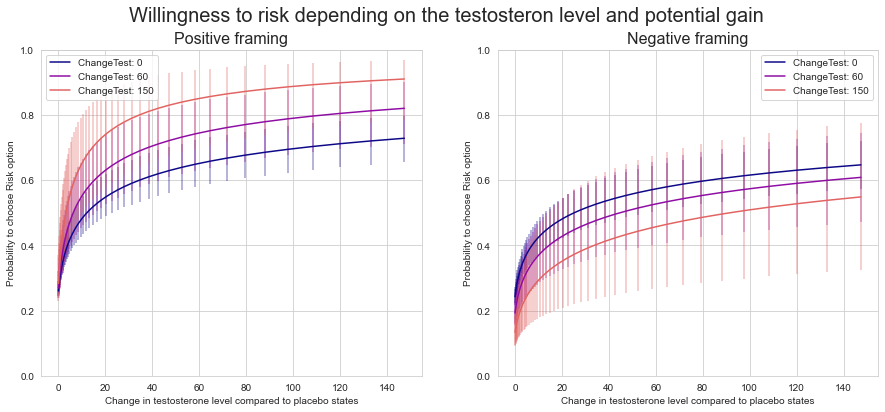

In [44]:
gap_sens_testn(trace_7)

### Risk sensitivity to gain (binary outcome: Place, Testosteronr)

In [45]:
def risk_sens_gain(trace, gaps, cr_int = 0.7):
    plt.figure(figsize = (15,6))
    
    alpha_bounds = az.hpd(trace['a'], credible_interval=cr_int)
    alpha_mu = trace['a'].mean(axis=0)
    beta_bounds = az.hpd(trace['beta'],credible_interval=cr_int)
    beta_mu = trace['beta'].mean(axis=0)
    
    def theta_errs(ind):
        theta = invlogit(alpha_mu[ind]+beta_mu[ind]*gaps)
        theta_lb = invlogit(alpha_bounds[ind,0]+beta_bounds[ind,0]*gaps)
        theta_ub = invlogit(alpha_bounds[ind,1]+beta_bounds[ind,1]*gaps)
        return theta, theta_lb, theta_ub
    
    plt.suptitle('Willingness to risk depending on the potential gain', fontsize = 20)

    theta_W_PL, theta_W_Pl_lb, theta_W_Pl_ub = theta_errs(0)
    plt.subplot(1,2,1); plt.plot(np.expm1(gaps), theta_W_PL, label = 'Placebo'); plt.ylim(0,1); plt.legend()
    plt.vlines(np.expm1(gaps), theta_W_Pl_lb,theta_W_Pl_ub, colors='black', alpha=0.5)

    theta_W_T, theta_W_T_lb, theta_W_T_ub = theta_errs(1)
    plt.subplot(1,2,1);plt.plot(np.expm1(gaps), theta_W_T, label = 'Testosterone'); plt.ylim(0,1); 
    plt.vlines(np.expm1(gaps), theta_W_T_lb,theta_W_T_ub, colors='red' , linestyles = 'dotted', alpha=0.9)
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Subjective money')
    plt.title('Winning framing', size = 16)
    plt.legend()

    
    theta_W_PL, theta_W_Pl_lb, theta_W_Pl_ub = theta_errs(2)
    plt.subplot(1,2,2); plt.plot(np.expm1(gaps), theta_W_PL, label = 'Placebo'); plt.ylim(0,1); 
    plt.vlines(np.expm1(gaps), theta_W_Pl_lb,theta_W_Pl_ub, colors='black', alpha=0.5)
    

    theta_W_T, theta_W_T_lb, theta_W_T_ub = theta_errs(3)
    plt.subplot(1,2,2);plt.plot(np.expm1(gaps), theta_W_T, label = 'Testosterone'); plt.ylim(0,1); 
    plt.vlines(np.expm1(gaps), theta_W_T_lb,theta_W_T_ub, colors='red' , linestyles = 'dotted', alpha=0.9)
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Subjective money')
    plt.title('Loss framing', size = 16)

    plt.legend()
    

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


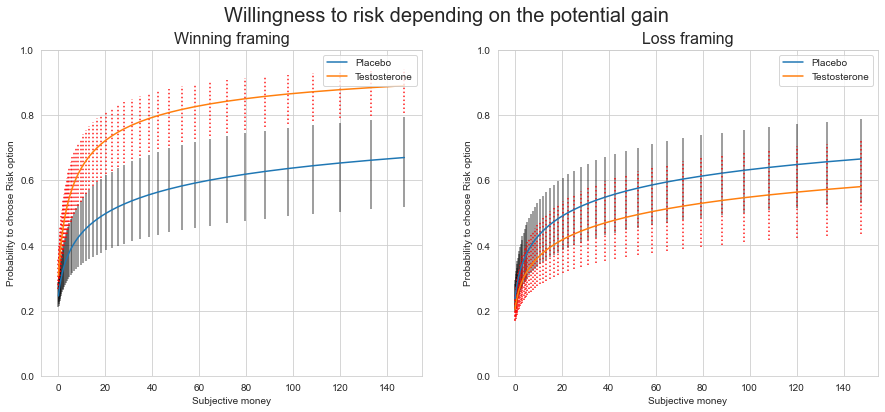

In [46]:
gaps = np.linspace(0,5,50)

risk_sens_gain(trace_6, gaps, cr_int = 0.7)